<a href="https://colab.research.google.com/github/rafsantos/tcc_colab_py/blob/main/Convolucao%20PeB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

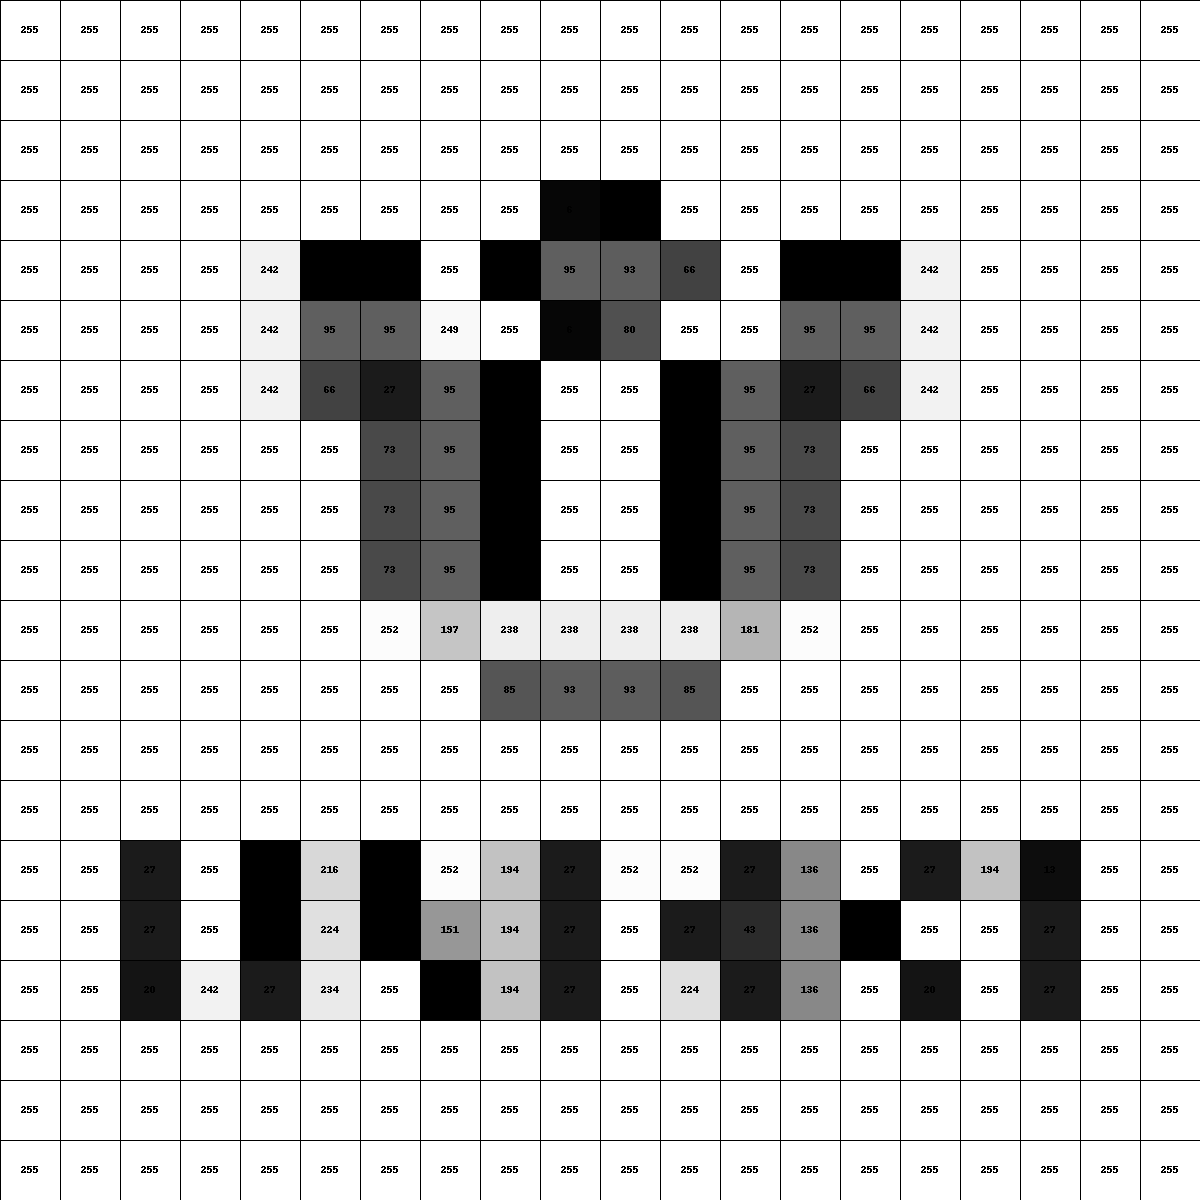

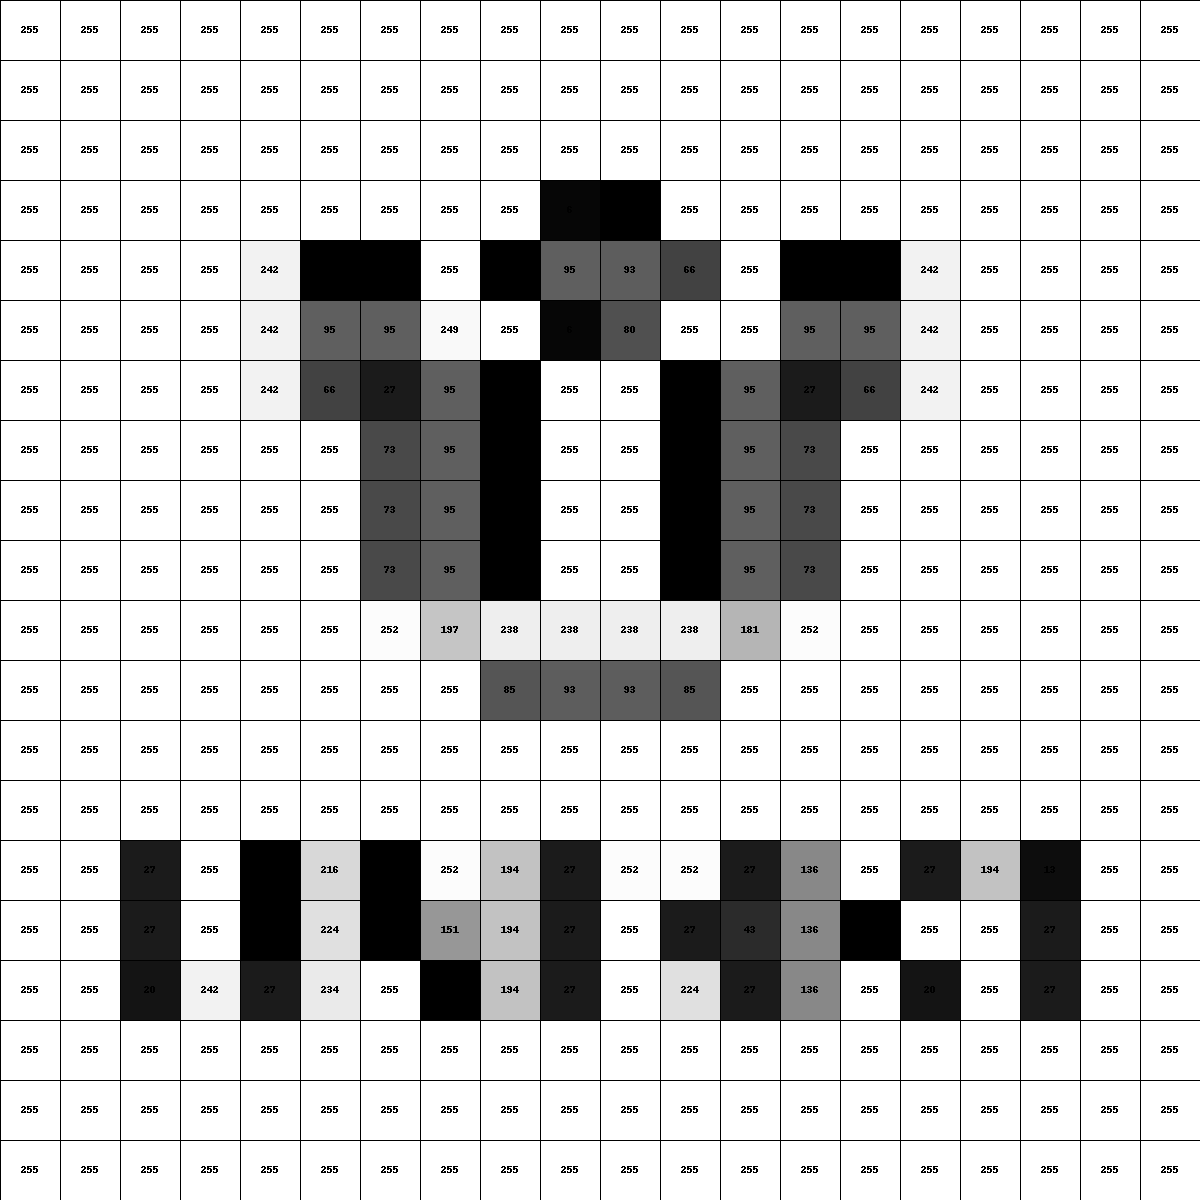

In [76]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import requests

def convolucao(image, filter):

   return image


#Desenha grade em uma imagem com um determinado intervalo
def grade(img,intervalo):
  img = np.array(img)
  img[::intervalo] = 0
  img[:,::intervalo] = 0
  img = Image.fromarray(img.astype('uint8'),'L')
  return img

def leImagemWeb(url):
  im = Image.open(requests.get(url, stream=True).raw).convert('L')
  return im

def ajustaVisual(img,pixLarg,fator):
  #compacta primeiro
  img = img.resize((20,20),resample=Image.NEAREST)
  img = img.resize((img.size[0]*fator,img.size[1]*fator),resample=Image.NEAREST)
  return img

def escrevePixels(img,fator):
  draw = ImageDraw.Draw(img)
  font = ImageFont.load_default()

  img_arr = np.array(img)

  for y in range(0,img_arr.shape[1],fator):
    for x in range(0,img_arr.shape[0],fator):
      txt = str(np.transpose(img_arr)[x,y])
      txtbox = font.getbbox(txt)
      #Alinhando o texto no centro do quadrado
      draw.text((x + fator/2 - txtbox[2]/2, y + fator/2 - txtbox[3]/2 ), txt, anchor='mm')
  return img



###############################################
fator = 60
pixHoriz = 20
# Vou obter uma imagem da web
#url = ("https://i.ibb.co/D81PNZz/image.png")
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSzFVq9sCTckUxKmHj7YTLlKQH6nkicNS_UQ9XUdvdeLg&s"
#url = 'https://live.staticflickr.com/4830/44200095760_4d993be1cb_b.jpg'



im_in = leImagemWeb(url)

filtro = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
    ], dtype=np.float32)/9.0

im_out = convolucao(im_in,filtro)

im_out_gd = ajustaVisual(im_out,pixHoriz,fator)

#escrevendo os valores de cada pixel
im_out_gd = escrevePixels(im_out_gd,fator)

#Desenha grade
im_out_gd = grade(im_out_gd,fator)
display(im_out_gd)

###### #############
##### ATE AQUI OK
#Fazendo convolucao


img_conv = convolucao(im_out_gd,filtro)
display(img_conv)

